In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Dataset from: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
# 1) id: unique identifier
# 2) gender: "Male", "Female" or "Other"
# 3) age: age of the patient
# 4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
# 5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
# 6) ever_married: "No" or "Yes"
# 7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
# 8) Residence_type: "Rural" or "Urban"
# 9) avg_glucose_level: average glucose level in blood
# 10) bmi: body mass index
# 11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
# 12) stroke: 1 if the patient had a stroke or 0 if not
# *Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [3]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# Drop the 1 sample with gender as "Other"
df = df[df['gender'] != "Other"]

# Drop id column
df = df.drop('id', axis=1)

In [5]:
# Label overview
df.stroke.value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


Missing bmi values.

## EDA

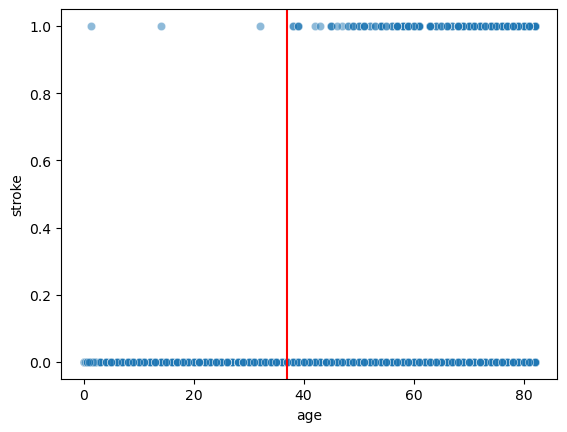

In [7]:
# Visualise the relationship between stroke and age
sns.scatterplot(x=df.age, y=df.stroke, alpha=.5)
plt.axvline(x=37, color='red');

The vast majority of stroke cases happen after the age of 37.

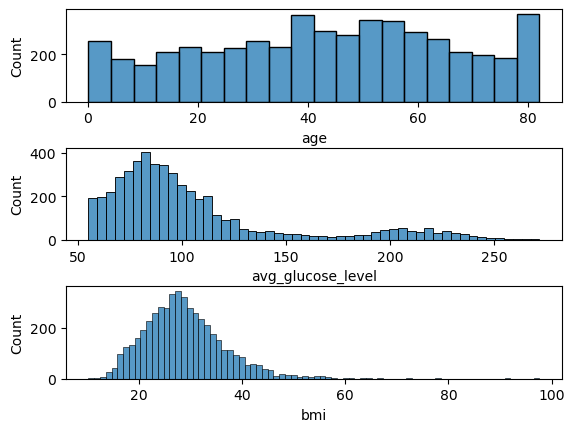

In [8]:
# Check for extreme outliers in ['age', 'avg_glucose_level', 'bmi']
fig, ax = plt.subplots(3, 1)
for i, cat in enumerate(['age', 'avg_glucose_level', 'bmi']):
    sns.histplot(df[cat], ax=ax[i])
    ax[i].set_xlabel(cat)
plt.subplots_adjust(hspace=0.5)

There are some people with really high, but possible, BMIs.

In [9]:
# Use correlation matrix to help with filling NaN bmi values
df.corr()

C:\Users\Darrel\AppData\Local\Temp\ipykernel_24204\975814664.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.276367,0.263777,0.238323,0.333314,0.245239
hypertension,0.276367,1.000000,0.108292,0.174540,0.167770,0.127891
heart_disease,0.263777,0.108292,1.000000,0.161907,0.041322,0.134905
avg_glucose_level,0.238323,0.174540,0.161907,1.000000,0.175672,0.131991
bmi,0.333314,0.167770,0.041322,0.175672,1.000000,0.042341
stroke,0.245239,0.127891,0.134905,0.131991,0.042341,1.000000


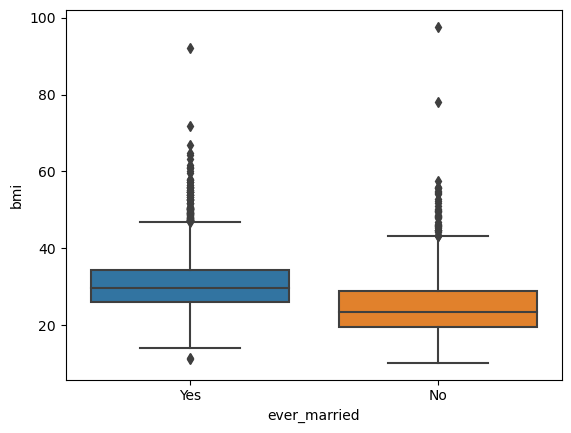

In [10]:
sns.boxplot(df, x='ever_married', y='bmi');

People who ever got married tend to have a higher BMI! Since the features ['age', 'hypertension', 'ever_married', 'avg_glucose_level'] have the highest correlation to BMI, I'll use them in filling the missing values.

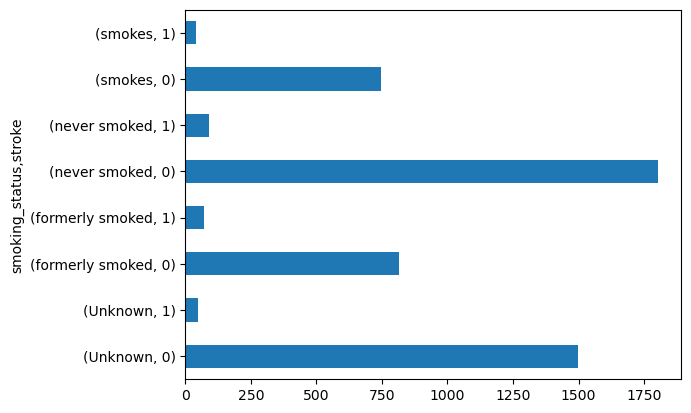

In [11]:
df.groupby(['smoking_status']).stroke.value_counts().plot(kind='barh');

In [12]:
df.groupby(['smoking_status']).stroke.value_counts(normalize=True)

smoking_status   stroke
Unknown          0         0.969560
                 1         0.030440
formerly smoked  0         0.920814
                 1         0.079186
never smoked     0         0.952431
                 1         0.047569
smokes           0         0.946768
                 1         0.053232
Name: stroke, dtype: float64

The incidence of stroke among the unknown group < never smoked group < smokes group < formerly smoked group, which suggests that the unknown group consists mostly of persons who never smoked.

## Data Preparation

In [13]:
from sklearn.model_selection import train_test_split
X = df.copy()
y = X.pop('stroke')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [14]:
def fill_missing(data, impute_strategy: str):
    """Fills in missing bmi values by using the mean or median bmi value of other samples that fall in
      the same age and avg_glucose_level ranges and have the same hypertension and ever_married values"""
    if impute_strategy not in ['mean', 'median']:
        raise Exception('Argument for impute_strategy is either "mean" or "median"')
    
    na_df = data.query('bmi.isna()')
    age_bins = np.arange(0, 101, 20)
    glucose_bins = np.arange(50, 301, 50)

    for i in range(0, len(na_df)):
        for age in age_bins: # Find out in which age range the current sample lies 
            if age <= na_df.iloc[i].age < age + 20:
                left_age = age
                right_age = age + 20
                break

        for glucose in glucose_bins: # Find out in which avg_glucose_level range the current sample lies in
            if glucose <= na_df.iloc[i].avg_glucose_level < glucose + 50:
                left_glucose = glucose
                right_glucose = glucose + 50
                break
        
        na_hypertension = na_df.iloc[i].hypertension # Find out the current sample's hypertension value
        na_ever_married = na_df.iloc[i].ever_married # Find out the current sample's ever_married value
        na_loc = na_df.iloc[i].name # Find out the index of the current sample

        bmi_query = data.query('age.between(@left_age, @right_age, inclusive="left") \
                               and avg_glucose_level.between(@left_glucose, @right_glucose, inclusive="left") \
                               and hypertension == @na_hypertension \
                               and ever_married == @na_ever_married').bmi
        
        if bmi_query.sum() == 0: # Loosen the grouping conditions by dropping the avg_glucose_level criterion
            bmi_query = data.query('age.between(@left_age, @right_age, inclusive="left") \
                                    and hypertension == @na_hypertension \
                                    and ever_married == @na_ever_married').bmi
        
        if impute_strategy == 'mean':
            new_value = bmi_query.apply('mean')
        elif impute_strategy == 'median':
            new_value = bmi_query.apply('median')
        
        data.loc[na_loc, 'bmi'] = new_value
            
    return data

In [15]:
def add_age_bin(data):
    """Ages <38 will be classified as 0 while ages >= 38 will be classified as 1"""
    age_bins = pd.cut(data.age, [0, 38, 100], right=False, labels=[0, 1])
    data['age_bin'] = age_bins
    return data

In [16]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from catboost import CatBoostClassifier

In [17]:
fill_missing_transformer = FunctionTransformer(fill_missing, kw_args={'impute_strategy': 'mean'})
add_age_bin_transformer = FunctionTransformer(add_age_bin)

ct = make_column_transformer((RobustScaler(), make_column_selector(dtype_exclude=object)),
                             (OneHotEncoder(), make_column_selector(dtype_include=object)))

preprocessing_pipeline = make_pipeline(fill_missing_transformer, add_age_bin_transformer, ct)

In [18]:
X_train = preprocessing_pipeline.fit_transform(X_train)
X_test = preprocessing_pipeline.transform(X_test)

## Model Training

In [ ]:
params = {'depth': [3, 4, 5, 6],
          'learning_rate': [0.05, 0.1, 0.3],
          'l2_leaf_reg': [1, 2, 3, 4]}

cbc = CatBoostClassifier(iterations=2000, random_seed=42, loss_function='Logloss', verbose=False, early_stopping_rounds=100, auto_class_weights='Balanced')
gridsearch_results = cbc.grid_search(param_grid=params, cv=3, X=X_train, y=y_train, stratified=True, 
                                     partition_random_seed=42, plot=True, search_by_train_test_split=False, refit=False)

In [20]:
# Get best hyperparameters
gridsearch_results['params']

{'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.05}

In [21]:
# Approximate the best iteration
pd.DataFrame(gridsearch_results['cv_results']).sort_values('test-Logloss-mean')

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
53,53,0.475288,0.012995,0.437451,0.001276
51,51,0.475457,0.012626,0.438973,0.002105
52,52,0.475612,0.012723,0.438572,0.001976
48,48,0.475620,0.012000,0.440660,0.002195
47,47,0.475683,0.012235,0.441418,0.001958
...,...,...,...,...,...
4,4,0.604509,0.001723,0.598513,0.003893
3,3,0.618477,0.001487,0.614316,0.002648
2,2,0.633115,0.002786,0.631222,0.003905
1,1,0.650069,0.000410,0.649149,0.001332


## Model Evaluation

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

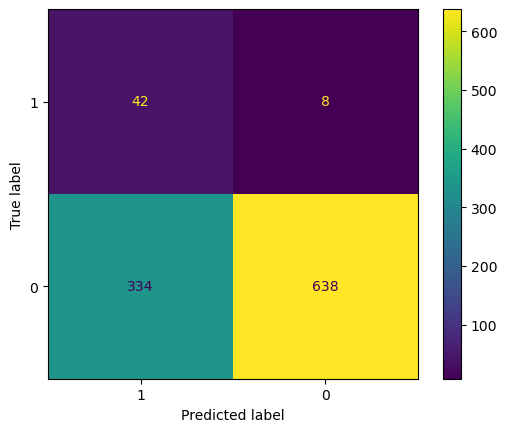

In [23]:
# Train model using best hyperparameter
cbc = CatBoostClassifier(iterations=54, random_seed=42, loss_function='Logloss', verbose=False, auto_class_weights='Balanced', depth=3, learning_rate=0.05, l2_leaf_reg=3)
cbc.fit(X_train, y_train)

# Evaluate model using confusion matrix
y_pred = cbc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[1,0])

The model correctly identifies 42/50 stroke samples but at the cost of 334 false positives. I'll now try to improve on this performance by engineering the 'smoking_status' feature and then retraining a new model. Specifically, I will try to replace the 'Unknown' value with predictions made using another CatBoost model.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [25]:
def convert_unknown_smoking_status(X, y, depth_list, lr_list, l2_list):
    """This function trains a CatBoost Classifier to predict replacement values for 'Unknown' values in the smoking_status feature"""
    X_known_status = X.query('smoking_status != "Unknown"')
    X_unknown_status = X.query('smoking_status == "Unknown"').drop('smoking_status', axis=1)

    y_known_status = X_known_status.pop('smoking_status')
    unknown_indices = X_unknown_status.index

    params = {'depth': depth_list, 'learning_rate': lr_list, 'l2_leaf_reg': l2_list}

    cbc = CatBoostClassifier(iterations=2000, random_seed=42, loss_function='MultiClass', verbose=False, early_stopping_rounds=100)
    gridsearch_results = cbc.grid_search(param_grid=params, cv=3, X=X_known_status, y=y_known_status, stratified=True, 
                                         partition_random_seed=42, plot=False, search_by_train_test_split=False, refit=False)

    best_depth = gridsearch_results['params']['depth']
    best_lr = gridsearch_results['params']['learning_rate']
    best_l2 = gridsearch_results['params']['l2_leaf_reg']
    best_iteration = pd.DataFrame(gridsearch_results['cv_results']['test-MultiClass-mean']).sort_values(0).index[0] + 1

    cbc = CatBoostClassifier(iterations=best_iteration, random_seed=42, loss_function='MultiClass', verbose=False,
                             depth=best_depth, learning_rate=best_lr, l2_leaf_reg=best_l2)
    cbc.fit(X_known_status, y_known_status)
    X.loc[unknown_indices, 'smoking_status'] = cbc.predict(X_unknown_status)
    dummies = pd.get_dummies(X.smoking_status)
    X = pd.concat((X, dummies), axis=1).drop('smoking_status', axis=1)
    
    return X

In [26]:
ct2 = make_column_transformer((RobustScaler(), make_column_selector(dtype_exclude=object)),
                             (OneHotEncoder(sparse_output=False), ['gender', 'ever_married', 'work_type', 'Residence_type']), 
                             verbose_feature_names_out=False, remainder='passthrough')
ct2.set_output(transform='pandas')

preprocessing_pipeline2 = make_pipeline(fill_missing_transformer, add_age_bin_transformer, ct2)

In [27]:
X_train = preprocessing_pipeline2.fit_transform(X_train)
X_test = preprocessing_pipeline2.transform(X_test)

In [ ]:
X_train = convert_unknown_smoking_status(X_train, y_train, params['depth'], params['learning_rate'], params['l2_leaf_reg'])
X_test = convert_unknown_smoking_status(X_test, y_test, params['depth'], params['learning_rate'], params['l2_leaf_reg'])

In [29]:
X_train.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,age_bin,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,formerly smoked,never smoked,smokes
845,0.083333,0.0,0.0,-0.620011,0.516129,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0
3745,-0.444444,0.0,0.0,-0.210498,-0.763441,-1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0
4184,-0.277778,0.0,0.0,0.752050,-0.580645,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0
3410,-0.194444,0.0,0.0,0.458994,0.473118,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0
284,-0.861111,0.0,0.0,-0.261072,0.354839,-1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0


In [ ]:
cbc = CatBoostClassifier(iterations=2000, random_seed=42, loss_function='Logloss', verbose=False, early_stopping_rounds=100, auto_class_weights='Balanced')
gridsearch_results = cbc.grid_search(param_grid=params, cv=3, X=X_train, y=y_train, stratified=True, 
                                     partition_random_seed=42, plot=True, search_by_train_test_split=False, refit=False)

In [31]:
gridsearch_results['params']

{'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.05}

In [32]:
# Approximate the best iteration
pd.DataFrame(gridsearch_results['cv_results']).sort_values('test-Logloss-mean')

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
57,57,0.477929,0.014725,0.433842,0.003413
88,88,0.477957,0.015512,0.415181,0.003795
60,60,0.477975,0.014022,0.432057,0.003298
59,59,0.478015,0.014260,0.432702,0.003423
91,91,0.478040,0.015934,0.413826,0.004193
...,...,...,...,...,...
4,4,0.596774,0.001725,0.593078,0.004048
3,3,0.610868,0.004494,0.606957,0.006070
2,2,0.624616,0.008866,0.622308,0.009454
1,1,0.648247,0.004090,0.646540,0.005593


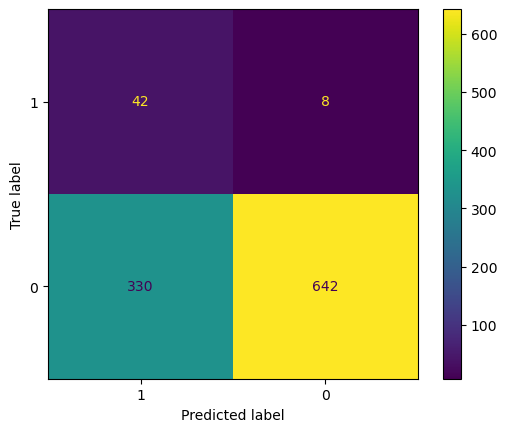

In [33]:
cbc = CatBoostClassifier(iterations=58, random_seed=42, loss_function='Logloss', verbose=False, auto_class_weights='Balanced', 
                         depth=3, learning_rate=0.05, l2_leaf_reg=3)
cbc.fit(X_train, y_train)

y_pred = cbc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[1,0])

Unfortunately, this approach only decreased the number of false positives by 4 from 334 to 330 while its performance in other areas remained the same.

In [34]:
cbc.get_feature_importance(prettified=True)

,Feature Id,Importances
0,age,49.299770
1,age_bin,26.163174
2,bmi,8.339254
3,avg_glucose_level,7.382270
4,ever_married_No,2.721723
5,gender_Female,2.293583
6,hypertension,1.295563
7,never smoked,0.854757
8,smokes,0.330757
9,Residence_type_Rural,0.202220


## Error Analysis

In [35]:
# fp_indices = y_test[(y_pred - y_test) == 1].index
fn_indices = y_test[(y_pred - y_test) == -1].index

In [36]:
# Examine the false negative samples
df.loc[fn_indices]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
133,Female,38.0,0,0,Yes,Private,Rural,101.45,NaN,formerly smoked,1
94,Male,45.0,0,0,Yes,Private,Rural,64.14,29.4,never smoked,1
182,Female,32.0,0,0,Yes,Private,Rural,76.13,29.9,smokes,1
88,Male,47.0,0,0,Yes,Private,Urban,86.94,41.1,formerly smoked,1
210,Female,39.0,0,0,Yes,Private,Urban,83.24,26.3,never smoked,1
245,Female,14.0,0,0,No,children,Rural,57.93,30.9,Unknown,1
31,Male,42.0,0,0,Yes,Private,Rural,83.41,25.4,Unknown,1
228,Female,39.0,0,0,Yes,Self-employed,Urban,97.76,29.6,smokes,1


* 2/8 of the false negatives coming from the age bin 0-37, which contains a total of only 3 stroke samples.
* Both bmi and avg_glucose_level values hover around their respective mean values; no particular value in any feature stand out.